# Image Segmentation on Forest Imagery

CSC 522 Fall 2024

- Anthony Wu, awu3
- Jheel Gala, jgala	
- Ophelia Sin, oysin
- Venkata Sai Praveen Gunda, vgunda



In [1]:
### import required packages

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data Preprocessing

In [2]:
base_dir = 'data'
#base_dir = 'data_new'

original_dir = os.path.join(base_dir, 'original')
mask_dir = os.path.join(base_dir, 'mask')


In [3]:
# Load and preprocess original image

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)  
    img = tf.image.resize(img, [224, 224])  
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [4]:
# Load mask

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    
    # Decode PNG image, keeping all channels (including alpha)
    mask = tf.image.decode_png(mask, channels=4)  # RGBA (4 channels)

    # Extract the alpha channel (transparency)
    alpha_channel = mask[:, :, 3]  # Alpha channel is the 4th channel

    # Create a binary mask: 1 for opaque (non-transparent), 0 for transparent
    binary_mask = tf.cast(alpha_channel > 0, tf.float32)

    # Resize the binary mask to match (224x224)
    binary_mask = tf.image.resize(binary_mask[..., tf.newaxis], [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return binary_mask

In [5]:
# Function to load both image and mask together
def load_image_and_mask(image_path, mask_path):
    image = load_and_preprocess_image(image_path)
    mask = load_mask(mask_path)
    return image, mask

In [6]:
# Get list of all images and masks
original_paths = sorted([os.path.join(original_dir, fname) for fname in os.listdir(original_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

In [7]:
# Create TensorFlow Dataset from the file paths of original images and masks
dataset = tf.data.Dataset.from_tensor_slices((original_paths, mask_paths))
print(dataset.element_spec)
buffer_size = 1000
dataset = dataset.shuffle(buffer_size)
dataset = dataset.map(load_image_and_mask)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


In [8]:
# Split the dataset into training, validation, and test datasets
total_count = len(list(dataset))
train_count = int(0.7 * total_count)
validation_count = int(0.1 * total_count)
test_count = int(0.2 * total_count)


train_dataset = dataset.take(train_count)
remaining = dataset.skip(train_count)
val_dataset = remaining.take(validation_count)
test_dataset = remaining.skip(validation_count)

2024-11-26 11:05:54.288849: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 11:05:54.295950: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 11:05:54.298066: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 11:05:54.302572: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 11:05:54.304940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 11:05:54.309272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 11:05:54.310217: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 11:05:54.311311: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 11:05:54.317524: W tensorflow/core/lib/png/png_io.cc:89] PNG 

In [9]:
validation_count

9

### Visualizing the Images

In [10]:
# def display(display_list):
#   plt.figure(figsize=(15, 15))

#   title = ['Input Image', 'True Mask',]

#   for i in range(len(display_list)):
#     plt.subplot(1, len(display_list), i+1)
#     plt.title(title[i])
#     plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
#     plt.axis('off')
#   plt.show()

In [11]:
# for images, masks in train_batches.take(3):
#   sample_image, sample_mask = images[0], masks[0]
#   display([sample_image, sample_mask])

## Prepare for Modeling

In [12]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomRotation(0.2, seed=seed),
            tf.keras.layers.RandomZoom(0.2, seed=seed)
        ])
        
    self.augment_labels = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
        tf.keras.layers.RandomRotation(0.2, seed=seed),
        tf.keras.layers.RandomZoom(0.2, seed=seed)
    ])

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [13]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [14]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# Prepare the validation dataset without data augmentation
validation_batches = (
    val_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Prepare the test dataset without data augmentation
test_batches = (
    test_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [15]:
from tensorflow_examples.models.pix2pix import pix2pix

# Pretrained network
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Default Architecture

In [ ]:
# Specific layers in MobileNetV2
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project'      # 4x4
]

# Get output layers corresponding to the layer names
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create submodel of MobileNetV2 

# Intermediate computations still present in model. These layers are still computing the fetaure maps fro the selected layers.  
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Freezing Weights for Pretrained Model

# ❗️play with the model layers that I want to freeze 
# code would look something like:
# for layer in down_stack.layers[:-23]: # freeze all layers except the last 23
#     layer.trainable = False

down_stack.trainable = False


In [17]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model=unet_model(output_channels=OUTPUT_CLASSES)

In [28]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true,[1, 2, 3]) + tf.reduce_sum(y_pred,[1, 2, 3]) - intersection
    iou = intersection / union
    return iou

In [ ]:
model.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

### Training with 1-Fold

In [21]:
EPOCHS = 20
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history = model.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

Epoch 1/20


2024-11-21 13:56:28.508758: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:28.512292: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:28.513176: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:28.514692: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:28.516979: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:28.519706: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:28.533785: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:28.540620: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:28.543032: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3374 - iou_metric: 0.1852 - loss: 0.8523

2024-11-21 13:56:34.205448: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:34.212405: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:34.218261: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:34.218920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:34.223842: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:34.225332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:34.228338: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:34.230662: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 13:56:34.233599: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3526 - iou_metric: 0.1832 - loss: 0.8416 - val_accuracy: 0.6196 - val_iou_metric: 0.1583 - val_loss: 0.6838 - learning_rate: 0.0010
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6384 - iou_metric: 0.1718 - loss: 0.6201 - val_accuracy: 0.7364 - val_iou_metric: 0.1242 - val_loss: 0.5688 - learning_rate: 0.0010
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - accuracy: 0.7769 - iou_metric: 0.1405 - loss: 0.5196 - val_accuracy: 0.8132 - val_iou_metric: 0.0801 - val_loss: 0.4985 - learning_rate: 0.0010
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7839 - iou_metric: 0.0888 - loss: 0.4797 - val_accuracy: 0.8213 - val_iou_metric: 0.0490 - val_loss: 0.4535 - learning_rate: 0.0010
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8156 - iou_metric: 0.1030 - loss: 0.4128 - val_accuracy: 0.8262 - val_iou_metric: 0.0648 - val_loss: 0.4237 - learning_rate: 0.0010
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 504m

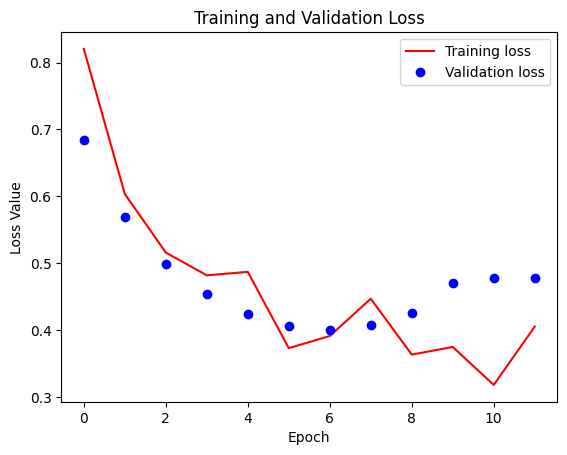

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

#### Predictions

In [64]:
predicted = model.predict(test_batches)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


In [68]:
predicted_masks = (predicted>0.6).astype(int)

In [69]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - accuracy: 0.8855 - iou_metric: 0.4316 - loss: 0.3348
Test Loss: 0.33477717638015747
Test IOU: 0.43157893419265747
Test Accuracy: 88.55%


In [ ]:
import matplotlib.pyplot as plt

# Function to display images, ground truth masks, and predicted masks
def display_sample(image, ground_truth, prediction):
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction, cmap='gray')

    plt.show()

In [ ]:
# Iterate through the test dataset and display results
def display_results(model, test_dataset, threshold=0.5):
    for images, masks in test_dataset.take(5):
        preds = model.predict(images)
        predicted_masks = (preds>threshold).astype(np.uint8)
        for i in range(len(images)):
            display_sample(images[i].numpy(), masks[i].numpy().squeeze(), predicted_masks[i].squeeze())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


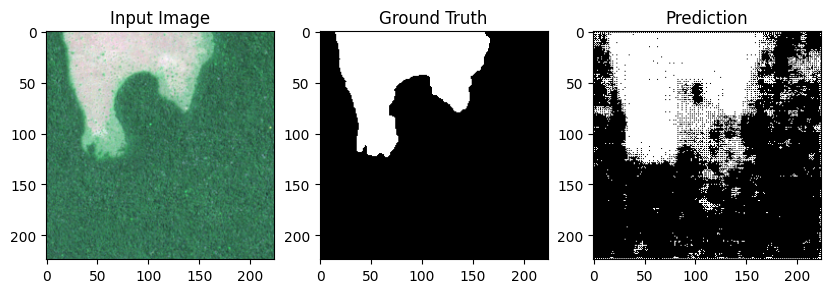

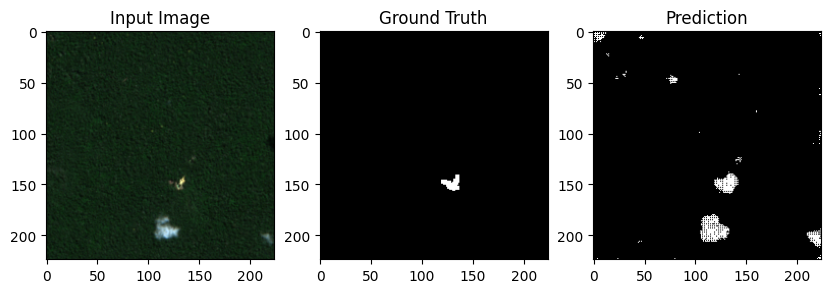

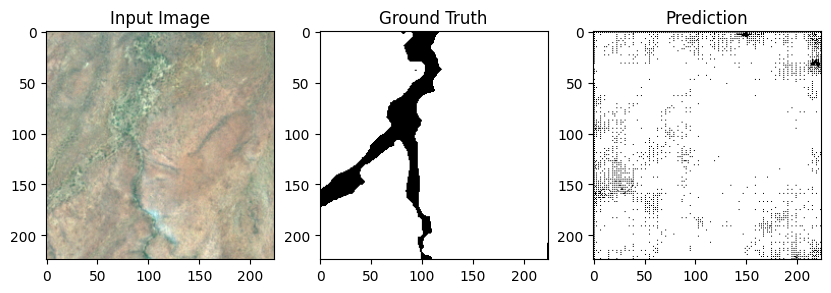

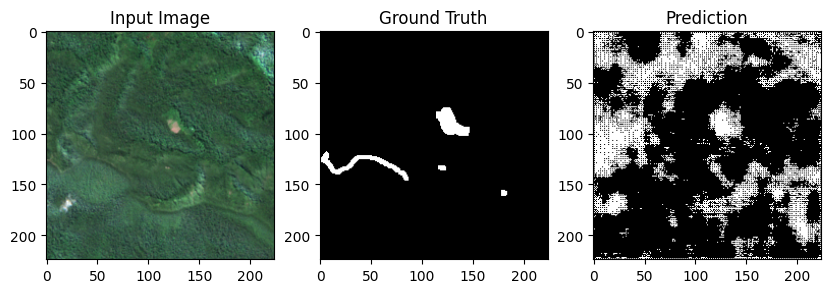

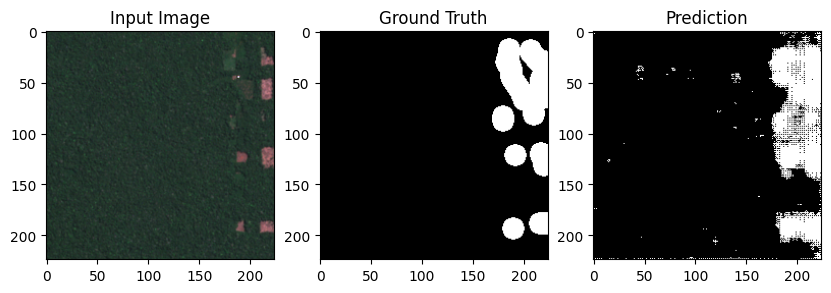

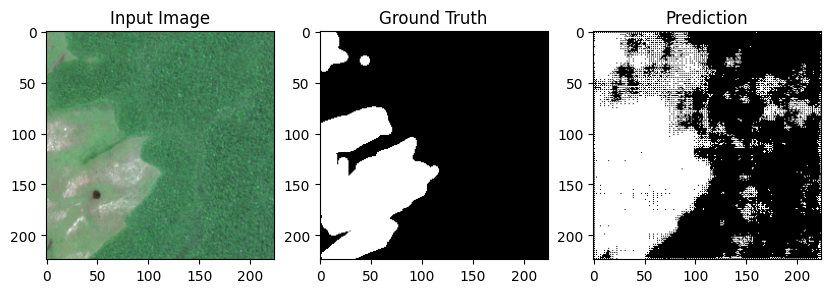

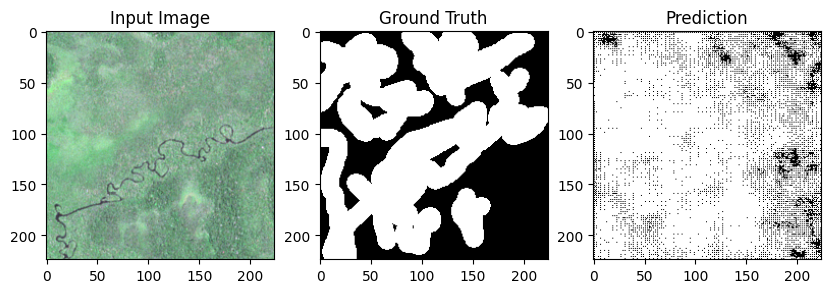

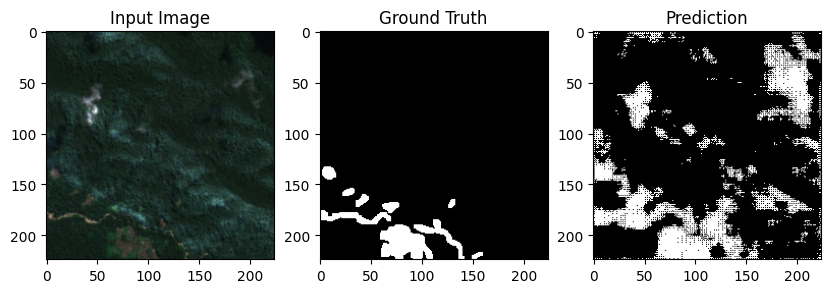

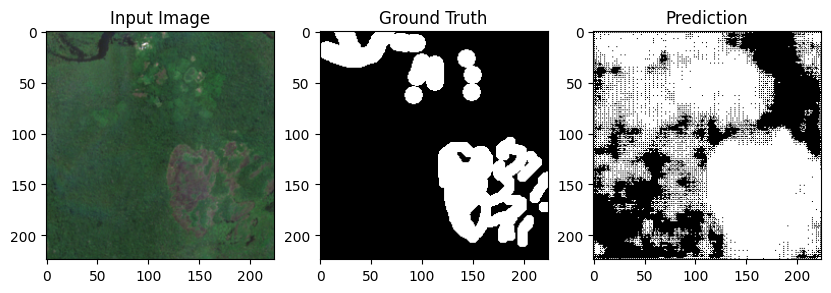

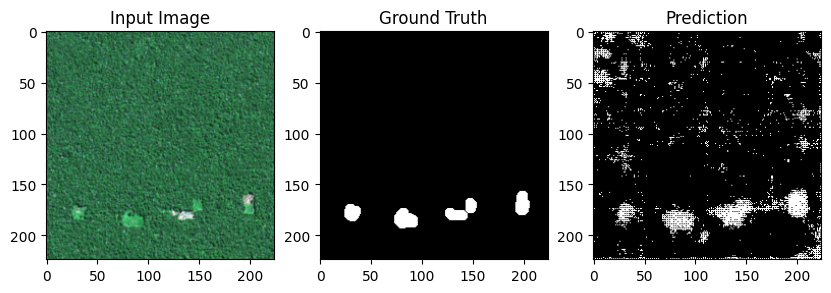

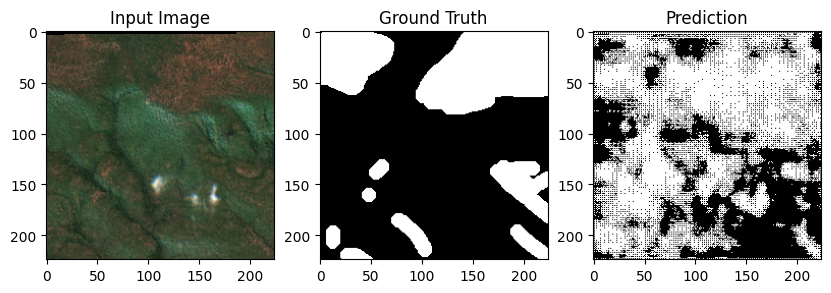

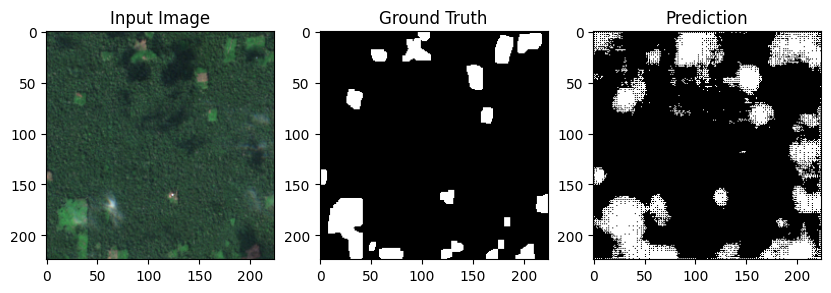

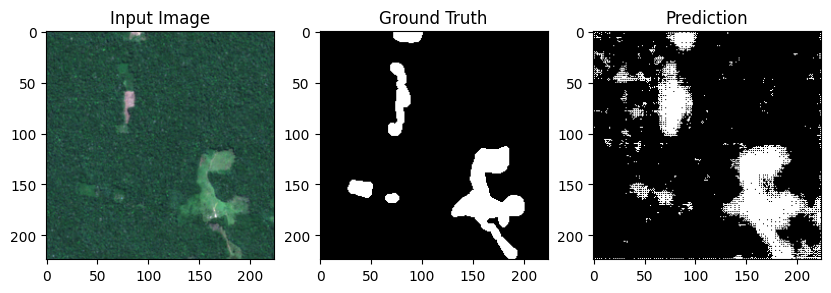

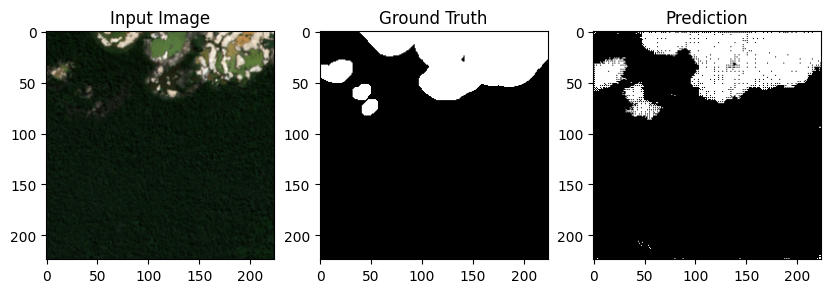

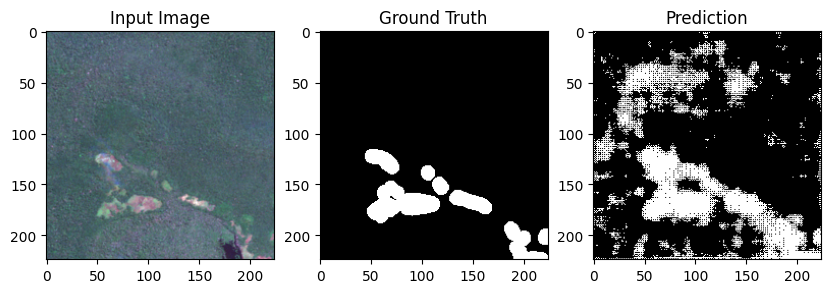

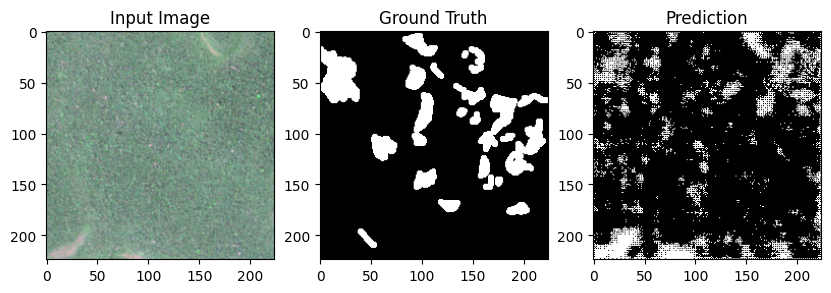

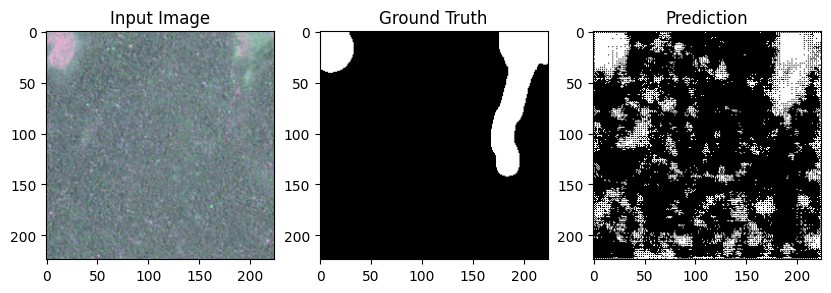

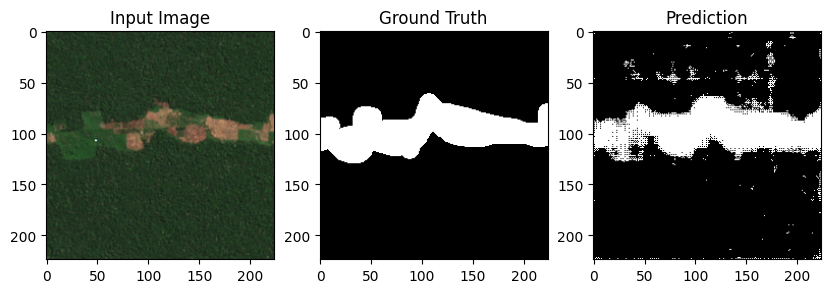

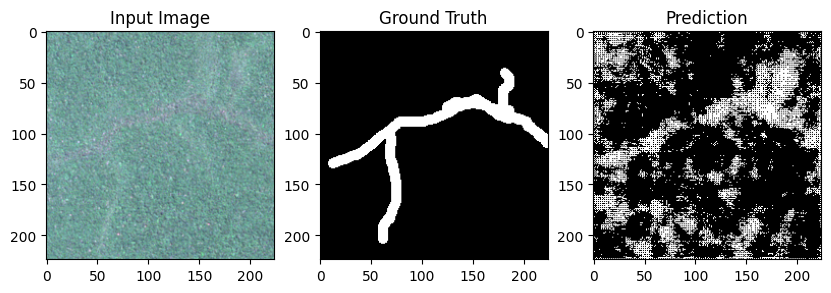

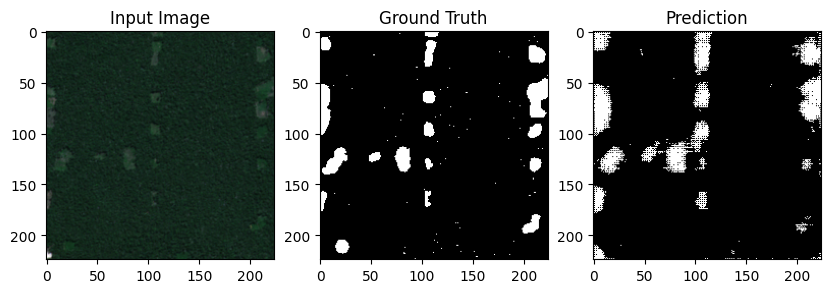

In [ ]:
display_results(model, test_batches, threshold=0.6)

### K-Fold Cross Validation

In [51]:
from sklearn.model_selection import KFold

# Number of folds
k_folds = 5
EPOCHS = 20
BATCH_SIZE = 32
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

dataset_size = len(list(dataset))  # Get the total size of the dataset

# Split the dataset into 80% training and 20% test sets
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Use Dataset.take() and Dataset.skip() to split the dataset
train_dataset_full = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Initialize KFold from scikit-learn
kf = KFold(n_splits=k_folds, shuffle=True)

val_accuracies = []
val_losses = []
val_ious = []
# Loop over each fold
for fold in range(k_folds):
    print(f"Training fold {fold + 1}/{k_folds}...")

    # Split dataset into training and validation sets for this fold
    # train_data = [dataset_list[i] for i in train_idx]
    # val_data = [dataset_list[i] for i in val_idx]

    train_dataset_full_copy = train_dataset_full
    # Shard the dataset for training and validation sets
    def get_train_val_datasets(dataset, fold_num, num_folds):

        # Validation set: shard corresponding to this fold number
        val_dataset = dataset.shard(num_shards=num_folds, index=fold_num)
        
        # Training set: all other shards except the current fold number (using filter)
        train_dataset = dataset.enumerate().filter(lambda i, _: i % num_folds != fold_num).map(lambda _, data: data)

        return train_dataset, val_dataset
    
    # Remove index from datasets (if added)
    train_dataset, val_dataset = get_train_val_datasets(train_dataset_full_copy, fold, k_folds)
        
    # Convert lists back to tf.data.Dataset objects
    train_dataset = (train_dataset
        .batch(BATCH_SIZE)
        .cache()
        .shuffle(BUFFER_SIZE)
        .map(Augment())
        .repeat()
        .prefetch(buffer_size=tf.data.AUTOTUNE))
    
    val_dataset = (val_dataset
        .batch(BATCH_SIZE)
        .cache()
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))

    model = unet_model(output_channels=1)

    # Compile the model with appropriate loss function and metrics
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', iou_metric])  

    # Train the model on this fold's training data
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[callback, lr_schedule]
    )

    # Evaluate on validation set for this fold
    val_loss, val_accuracy, val_iou = model.evaluate(val_dataset)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy}")

    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    val_ious.append(val_iou)

2024-11-26 13:49:20.310743: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 13:49:20.316631: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 13:49:20.337695: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 13:49:20.343267: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 13:49:20.345543: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 13:49:20.346766: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 13:49:20.349206: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 13:49:20.351884: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 13:49:20.355930: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Training fold 1/5...


TypeError: unet_model() missing 2 required positional arguments: 'down_stack' and 'up_stack'

####  Predictions

In [ ]:
test_dataset = (test_dataset
                .batch(BATCH_SIZE)  # Ensure batching
                .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
predicted_k_fold = model.predict(test_dataset)
predicted_masks_k_fold = (predicted_k_fold>0.4).astype(int)

2024-11-21 10:56:19.961231: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:56:19.994767: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:56:20.007490: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:56:20.036388: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:56:20.044843: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:56:20.049765: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:56:20.052420: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:56:20.052600: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:56:20.055143: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2024-11-21 10:58:02.022651: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:58:02.022911: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:58:02.033742: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:58:02.035887: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:58:02.038264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:58:02.042719: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:58:02.042807: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:58:02.044107: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 10:58:02.049932: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step - accuracy: 0.8297 - iou_metric: 0.2583 - loss: 0.4471
Test Loss: 0.44712480902671814
Test IOU: 0.2583089768886566
Test Accuracy: 82.97%


2024-11-21 11:14:14.246431: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 11:14:14.246848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 11:14:14.254587: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 11:14:14.257869: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 11:14:14.260899: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 11:14:14.262129: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 11:14:14.265169: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 11:14:14.267706: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-21 11:14:14.278996: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


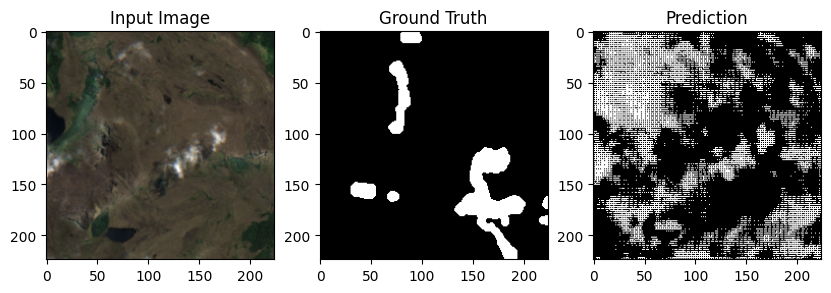

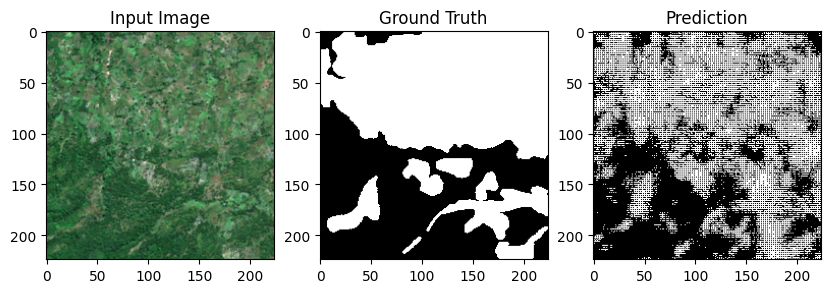

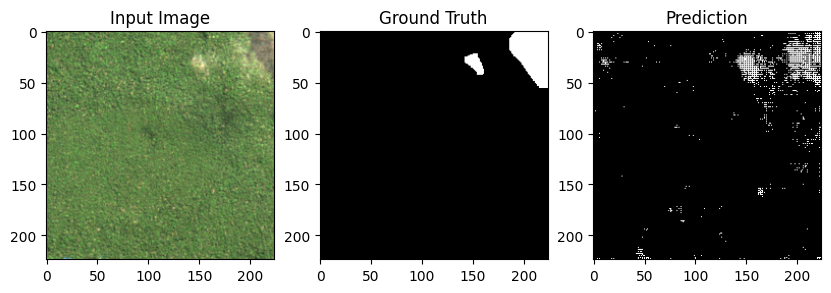

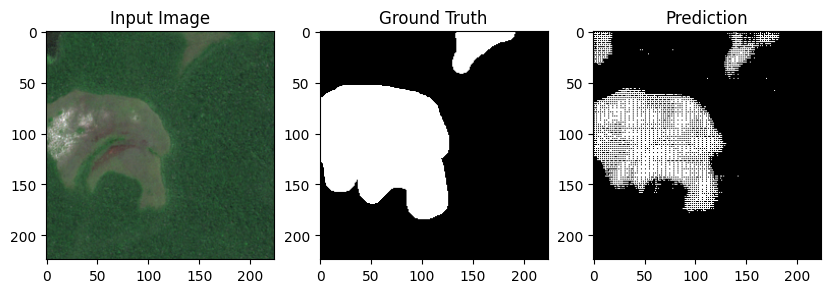

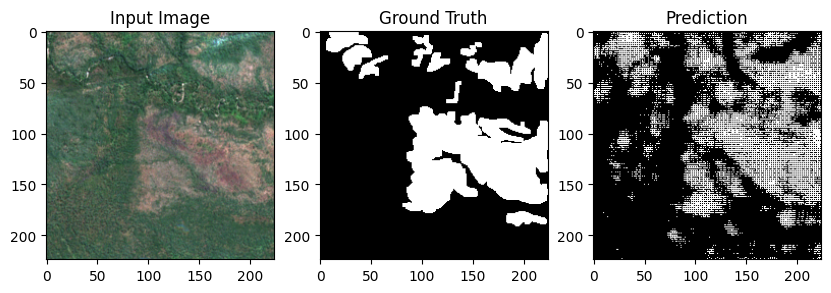

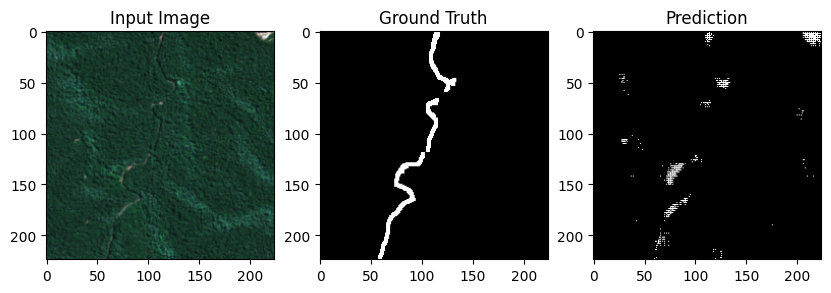

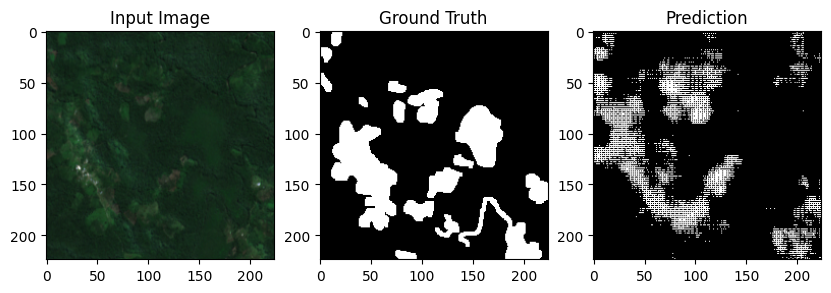

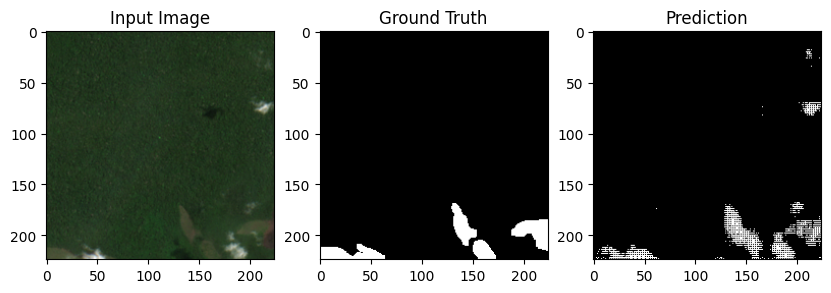

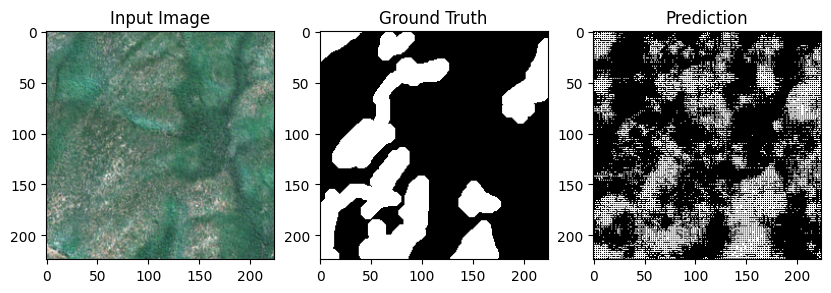

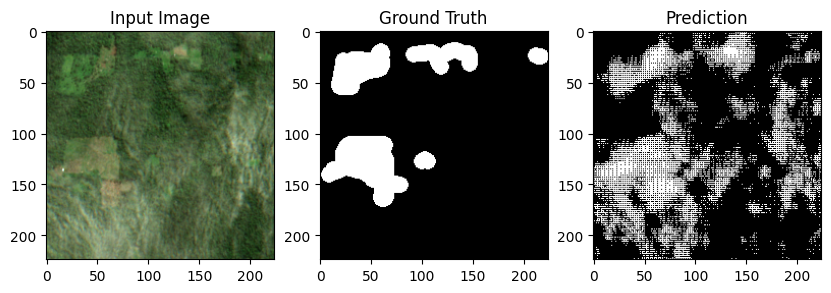

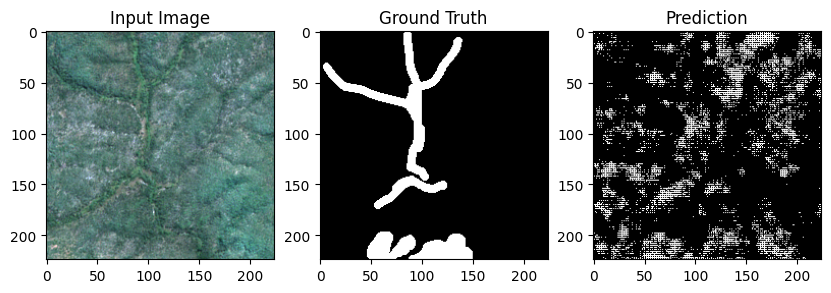

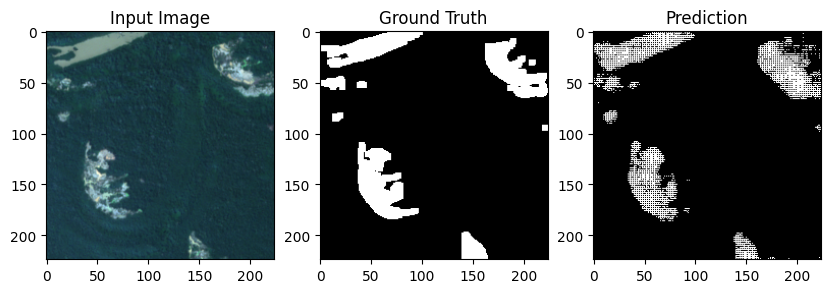

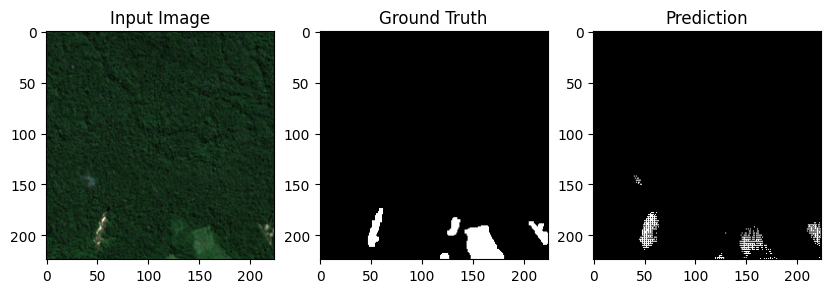

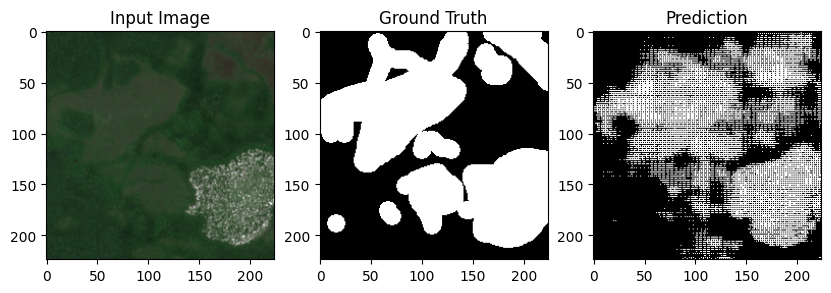

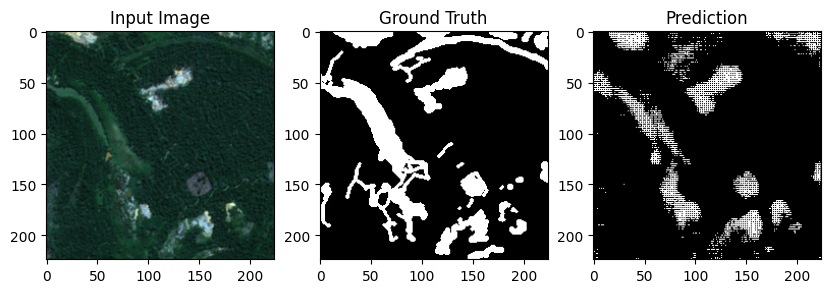

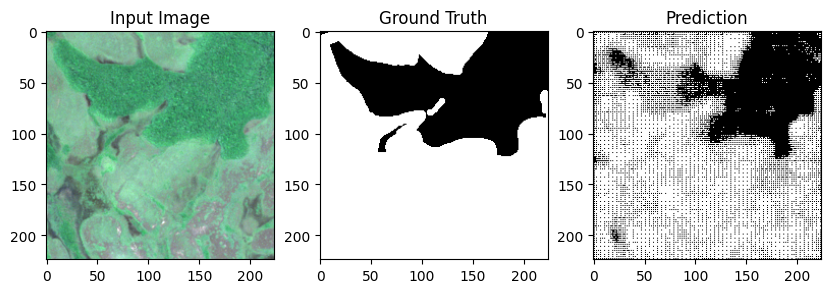

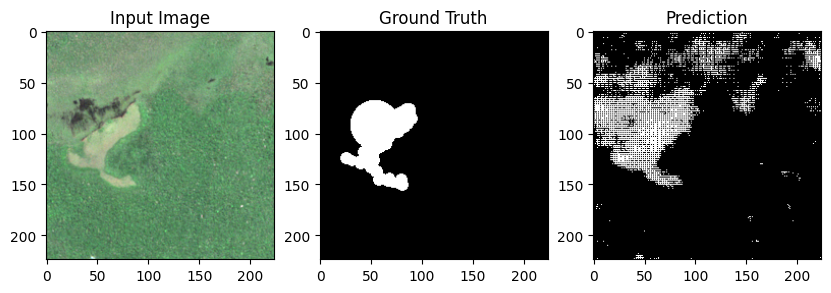

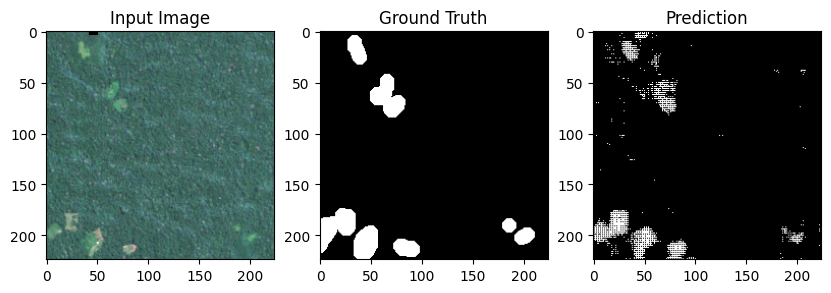

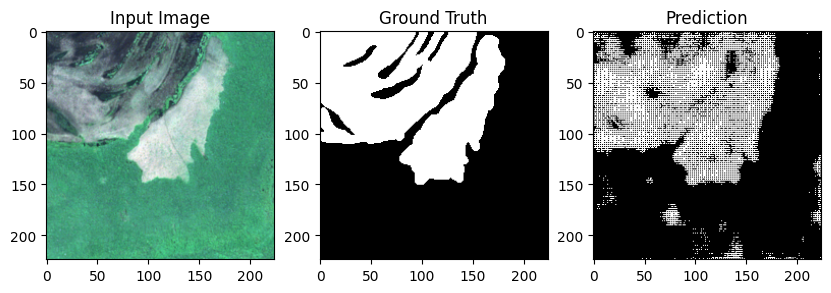

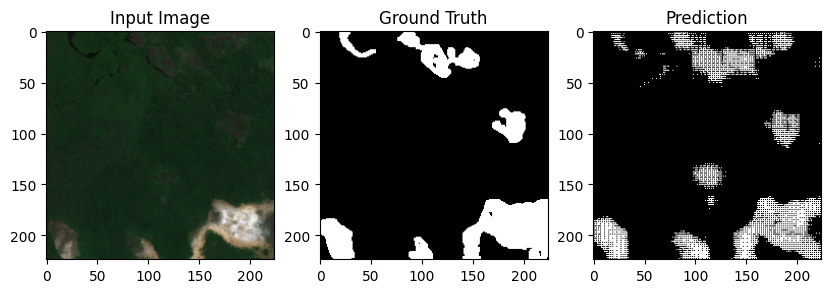

In [ ]:
display_results(model, test_dataset, threshold=0.6)

## Experiment with freezing layers

In [55]:
def unfreeze_layers(model, layers_to_unfreeze):
    """
    Unfreeze specific layers in the model by making them trainable.
    All other layers will remain frozen.
    
    Args:
        model: The Keras model containing the layers to unfreeze.
        layers_to_unfreeze: List of layer names to unfreeze.
    """
    for layer in model.layers:
        if layer.name in layers_to_unfreeze:
            layer.trainable = True  # Unfreeze the layer
        else:
            layer.trainable = False  # Keep the layer frozen
    print(f"Unfrozen layers: {layers_to_unfreeze}")

In [54]:
# Function to progressively unfreeze deeper to shallower layers
def progressively_unfreeze_layers(down_stack, unfreeze_depths):
    """
    Experiment with progressively unfreezing layers in the encoder (downstack).
    
    Args:
        down_stack: The encoder model (e.g., MobileNetV2).
        unfreeze_depths: List of depths to progressively unfreeze.
                        Each depth corresponds to a list of layer names.
    
    Returns:
        A list of models with different unfreezing configurations.
    """
    models = []
    
    for depth, layers_to_unfreeze in enumerate(unfreeze_depths):
        # Clone the downstack to avoid modifying the original
        cloned_down_stack = tf.keras.models.clone_model(down_stack)
        
        # Unfreeze the specified layers
        unfreeze_layers(cloned_down_stack, layers_to_unfreeze)
        
        # Add the modified downstack to the list of models
        models.append(cloned_down_stack)
        
        print(f"Experiment {depth + 1}: Unfrozen {len(layers_to_unfreeze)} layers.")
    
    return models

In [ ]:
def unet_model_unfreeze(output_channels:int, down_stack):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [57]:
layer_names = [
    'block_16_project',       # Deepest layer (7x7)
    'block_13_expand_relu',   # Deep layer (14x14)
    'block_6_expand_relu',    # Mid-level layer (28x28)
    'block_3_expand_relu',    # Shallow layer (56x56)
    'block_1_expand_relu'     # Shallowest layer (112x112)
]

# Define unfrozen layers
unfreeze_depths = [
    ['block_16_project'],                                  
    ['block_16_project', 'block_13_expand_relu'],          
    ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu'],  
    ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu', 'block_3_expand_relu'],  
    ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu', 'block_3_expand_relu', 'block_1_expand_relu'] 
]

# Create progressively unfrozen models
progressively_unfrozen_models = progressively_unfreeze_layers(down_stack, unfreeze_depths)

EPOCHS = 20
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


Unfrozen layers: ['block_16_project']
Experiment 1: Unfrozen 1 layers.
Unfrozen layers: ['block_16_project', 'block_13_expand_relu']
Experiment 2: Unfrozen 2 layers.
Unfrozen layers: ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu']
Experiment 3: Unfrozen 3 layers.
Unfrozen layers: ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu', 'block_3_expand_relu']
Experiment 4: Unfrozen 4 layers.
Unfrozen layers: ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu', 'block_3_expand_relu', 'block_1_expand_relu']
Experiment 5: Unfrozen 5 layers.


In [ ]:
for i, model in enumerate(progressively_unfrozen_models):
    print(f"\nModel {i + 1}: Trainable Layers")
    for layer in model.layers:
        if layer.trainable:
            print(layer.name)
    
    # Compile model
    OUTPUT_CLASSES = 1
    model=unet_model_unfreeze(output_channels=OUTPUT_CLASSES, down_stack = down_stack)

    model.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])
    
    # Train
    history = model.fit(
        train_batches,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=validation_batches,
        validation_steps=validation_steps,
        callbacks=[callback, lr_schedule]
    )